In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import hmmlearn
from hmmlearn import hmm

In [2]:
df = pd.read_csv('pricedata.csv')

In [3]:
df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,1/4/2000,23.90,24.70,23.89,24.39,32509,USD
1,Brent Oil,1/5/2000,24.25,24.37,23.70,23.73,30310,USD
2,Brent Oil,1/6/2000,23.55,24.22,23.35,23.62,44662,USD
3,Brent Oil,1/7/2000,23.57,23.98,23.05,23.09,34826,USD
4,Brent Oil,1/10/2000,23.04,23.78,23.04,23.73,26388,USD


In [4]:
df['Date'] = [dt.datetime.strptime(date_str, '%m/%d/%Y').date() for date_str in df['Date']]

In [5]:
df.set_index(df['Date'], inplace = True)
df.drop(columns = 'Date', inplace = True)

In [6]:
df['Symbol'].unique()

array(['Brent Oil', 'Crude Oil WTI', 'Natural Gas', 'Heating Oil'],
      dtype=object)

In [7]:
brent = df[df['Symbol'] == 'Brent Oil']
WTI = df[df['Symbol'] == 'Crude Oil WTI']
natural = df[df['Symbol'] == 'Natural Gas']
heating = df[df['Symbol'] == 'Heating Oil']

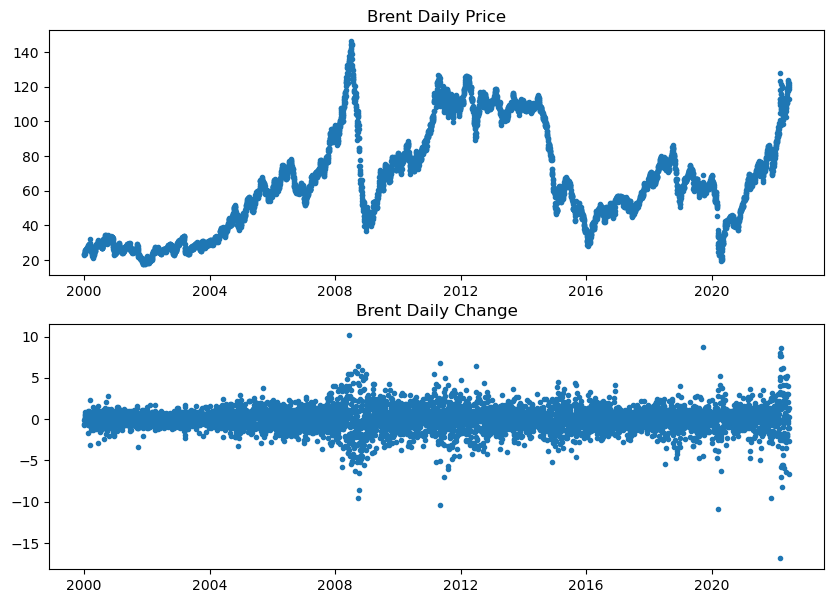

In [8]:
brent_price = brent['Close']
brent_diff = brent_price.diff().dropna()
brent_price = brent_price.iloc[1:]

plt.figure(figsize = (10, 7))
plt.subplot(2, 1, 1)
plt.plot(brent_price, '.')
plt.title('Brent Daily Price')

plt.subplot(2, 1, 2)
plt.plot(brent_diff, '.')
plt.title('Brent Daily Change')
plt.show()

In [9]:
X_train = brent_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()].values.reshape(-1, 1)
brent_price_train = brent_price[:dt.datetime(year = 2020, month = 1, day = 1).date()]
brent_diff_train = brent_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()]
brent_price_test = brent_price[dt.datetime(year = 2020, month = 1, day = 1).date():]

model = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 1000, random_state = 36)
model.fit(X_train)

GaussianHMM(n_components=3, n_iter=1000, random_state=36)

In [10]:
print(f"Start probabilities:\n{model.startprob_}\n") # Most likely to start in state 2
print(f"Transition matrix:\n{model.transmat_}\n") # Most likely to stay in same state
print(f"Gaussian Distribution Means:\n{model.means_}\n") # State 0 is decrease, 1 is small increase, and 2 is large increase
print(f"Gaussian Distribution Covariances:\n{model.covars_}") # Covariance of state 0 is largest, then state 1, and state 2 has smallest covariance

Start probabilities:
[3.28818217e-230 5.90449312e-032 1.00000000e+000]

Transition matrix:
[[9.72981089e-01 2.70189105e-02 4.33336192e-11]
 [8.57832765e-03 9.83215187e-01 8.20648525e-03]
 [1.12423378e-10 1.97075082e-02 9.80292492e-01]]

Gaussian Distribution Means:
[[-0.08311229]
 [ 0.01326108]
 [ 0.06294672]]

Gaussian Distribution Covariances:
[[[5.31971731]]

 [[1.25936556]]

 [[0.3220459 ]]]


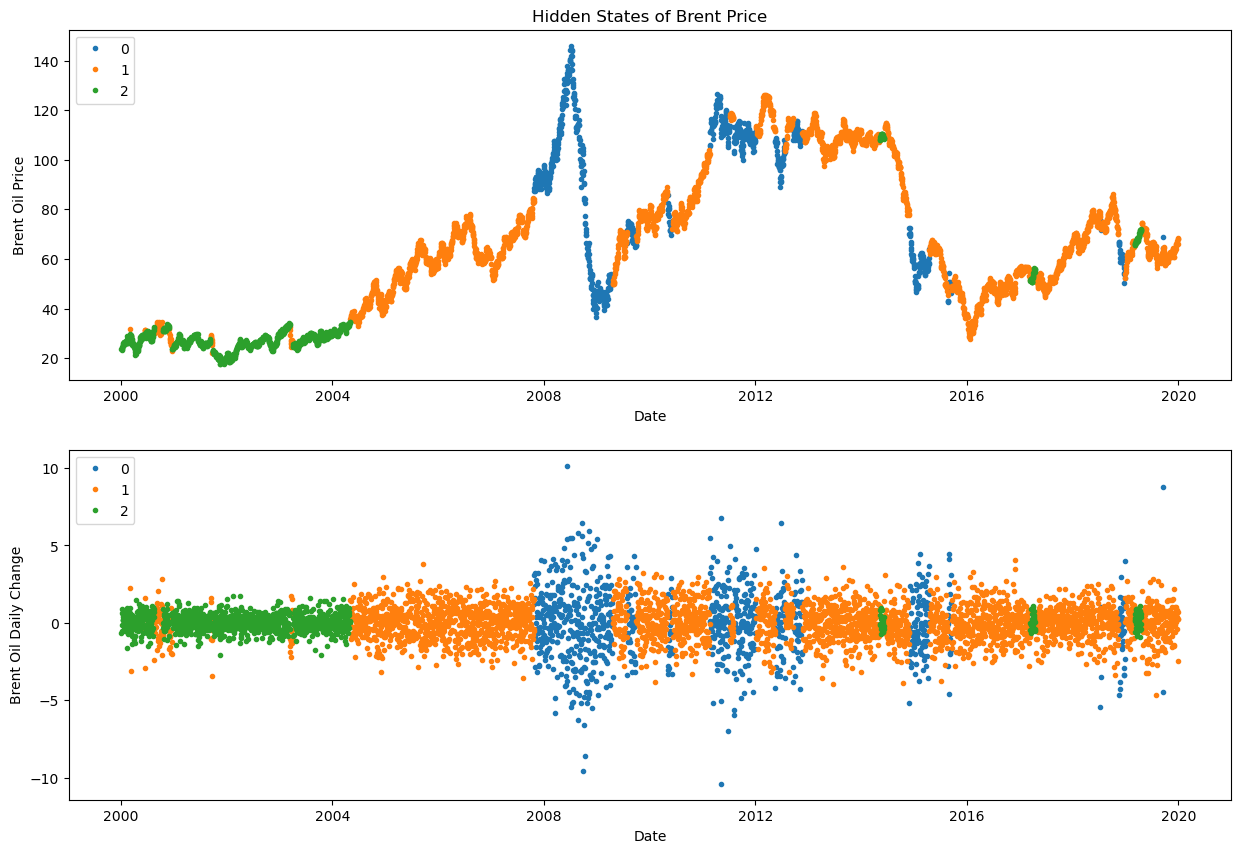

In [11]:
train_pred = model.predict(X_train)
model_states = np.sort(pd.unique(train_pred))


plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in model_states:
    state_idx = (train_pred == i)
    x = brent_price_train.index[state_idx]
    y = brent_price_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Brent Oil Price")
plt.title("Hidden States of Brent Price")
plt.legend(model_states, loc = 'upper left')


plt.subplot(2,1,2)
for i in model_states:
    state_idx = (train_pred == i)
    x = brent_diff_train.index[state_idx]
    y = brent_diff_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Brent Oil Daily Change")
plt.legend(model_states, loc = 'upper left')

plt.show()

In [12]:
last_state = train_pred[-1]
future_states = [last_state]

num_days = brent_price_test.shape[0]
np.random.seed(475)

# Predict future states based on last known state
for _ in range(num_days - 1):
    future_states.append(np.random.choice(range(model.n_components), p = model.transmat_[future_states[-1]]))

# Predict changes in price based on predicted states
future_returns = []
for state in future_states:
    future_returns.append(np.random.normal(model.means_[state][0], np.sqrt(model.covars_[state][0]))[0])

predicted_prices = [brent_price_train[-1]]
for ret in future_returns:
    predicted_prices.append(predicted_prices[-1] + ret)
    

predicted_prices = pd.Series(predicted_prices[1:], index = brent_price_test.index[0:(len(predicted_prices) - 1)])
test_prices = pd.concat([predicted_prices, brent_price_test[0:len(predicted_prices)]], axis = 1)
test_prices.columns = ['Predicted Price', 'Actual Price']

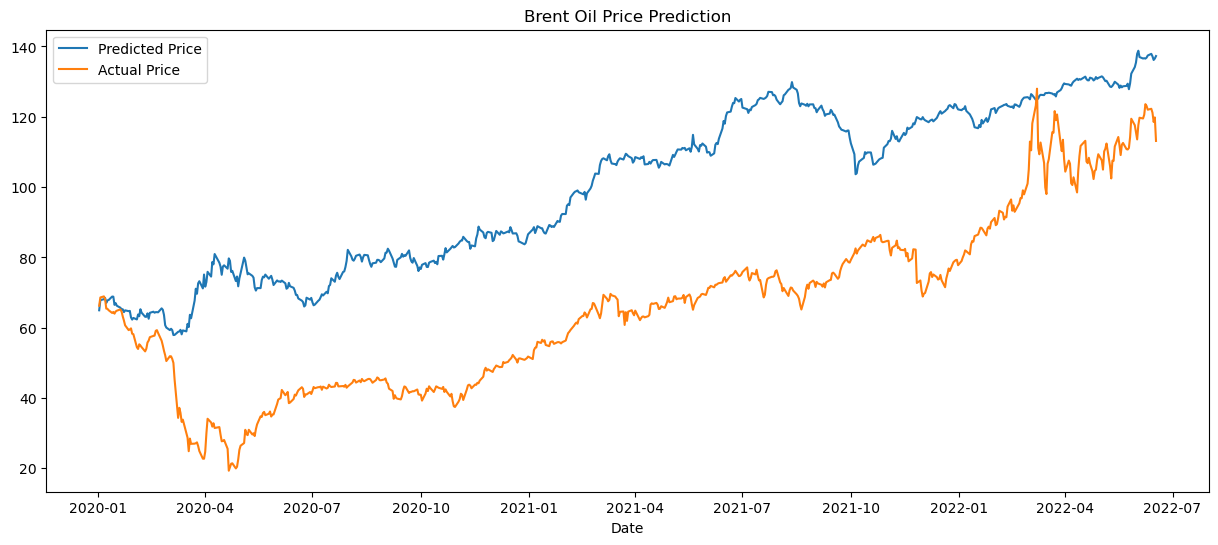

In [13]:
test_prices.plot(figsize = (15, 6), title = "Brent Oil Price Prediction")
plt.show()

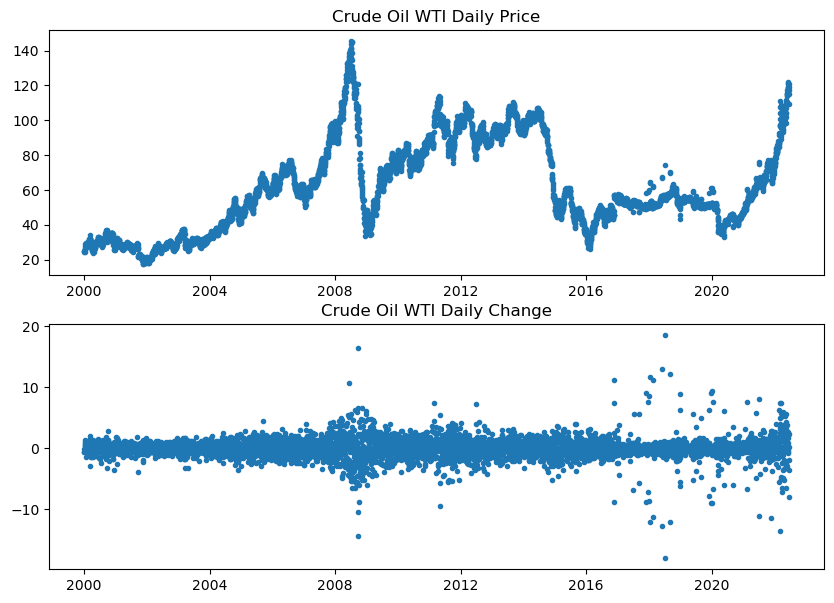

In [14]:
WTI_price = WTI['Close']
WTI_diff = WTI_price.diff().dropna()
WTI_price = WTI_price.iloc[1:]

plt.figure(figsize = (10, 7))
plt.subplot(2, 1, 1)
plt.plot(WTI_price, '.')
plt.title('Crude Oil WTI Daily Price')

plt.subplot(2, 1, 2)
plt.plot(WTI_diff, '.')
plt.title('Crude Oil WTI Daily Change')
plt.show()

In [15]:
X_train = WTI_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()].values.reshape(-1, 1)
WTI_price_train = WTI_price[:dt.datetime(year = 2020, month = 1, day = 1).date()]
WTI_diff_train = WTI_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()]
WTI_price_test = WTI_price[dt.datetime(year = 2020, month = 1, day = 1).date():]

model = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 1000, random_state = 36)
model.fit(X_train)

GaussianHMM(n_components=3, n_iter=1000, random_state=36)

In [16]:
print(f"Start probabilities:\n{model.startprob_}\n") # Most likely to start in state 0
print(f"Transition matrix:\n{model.transmat_}\n") # Most likely to stay in same state
print(f"Gaussian Distribution Means:\n{model.means_}\n") # State 0 is increase, 1 is small increase, and 2 is large decrease
print(f"Gaussian Distribution Covariances:\n{model.covars_}") # Covariance of state 0 is smallest, then state 1, and state 2 has largest covariance

Start probabilities:
[1.00000000e+00 5.12123426e-42 5.39842286e-61]

Transition matrix:
[[0.97922616 0.00781851 0.01295533]
 [0.00342596 0.99005915 0.00651489]
 [0.06730031 0.04170542 0.89099426]]

Gaussian Distribution Means:
[[ 0.03730104]
 [ 0.01024749]
 [-0.15912764]]

Gaussian Distribution Covariances:
[[[ 0.33786671]]

 [[ 1.72920526]]

 [[18.33255242]]]


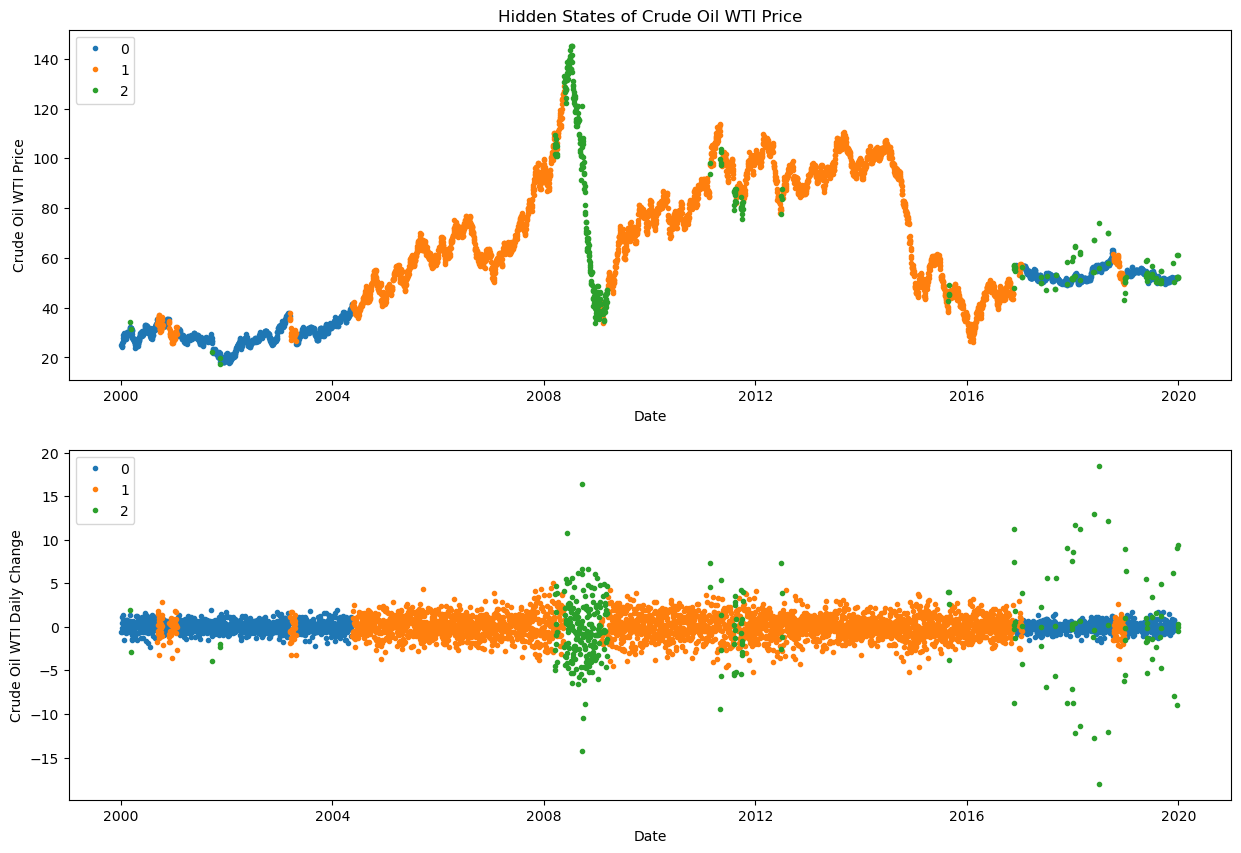

In [17]:
train_pred = model.predict(X_train)
model_states = np.sort(pd.unique(train_pred))


plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in model_states:
    state_idx = (train_pred == i)
    x = WTI_price_train.index[state_idx]
    y = WTI_price_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Crude Oil WTI Price")
plt.title("Hidden States of Crude Oil WTI Price")
plt.legend(model_states, loc = 'upper left')


plt.subplot(2,1,2)
for i in model_states:
    state_idx = (train_pred == i)
    x = WTI_diff_train.index[state_idx]
    y = WTI_diff_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Crude Oil WTI Daily Change")
plt.legend(model_states, loc = 'upper left')

plt.show()

In [18]:
last_state = train_pred[-1]
future_states = [last_state]

num_days = WTI_price_test.shape[0]
np.random.seed(475)

# Predict future states based on last known state
for _ in range(num_days - 1):
    future_states.append(np.random.choice(range(model.n_components), p = model.transmat_[future_states[-1]]))

# Predict changes in price based on predicted states
future_returns = []
for state in future_states:
    future_returns.append(np.random.normal(model.means_[state][0], np.sqrt(model.covars_[state][0]))[0])

predicted_prices = [WTI_price_train[-1]]
for ret in future_returns:
    predicted_prices.append(predicted_prices[-1] + ret)
    

predicted_prices = pd.Series(predicted_prices[1:], index = WTI_price_test.index[0:(len(predicted_prices) - 1)])
test_prices = pd.concat([predicted_prices, WTI_price_test[0:len(predicted_prices)]], axis = 1)
test_prices.columns = ['Predicted Price', 'Actual Price']

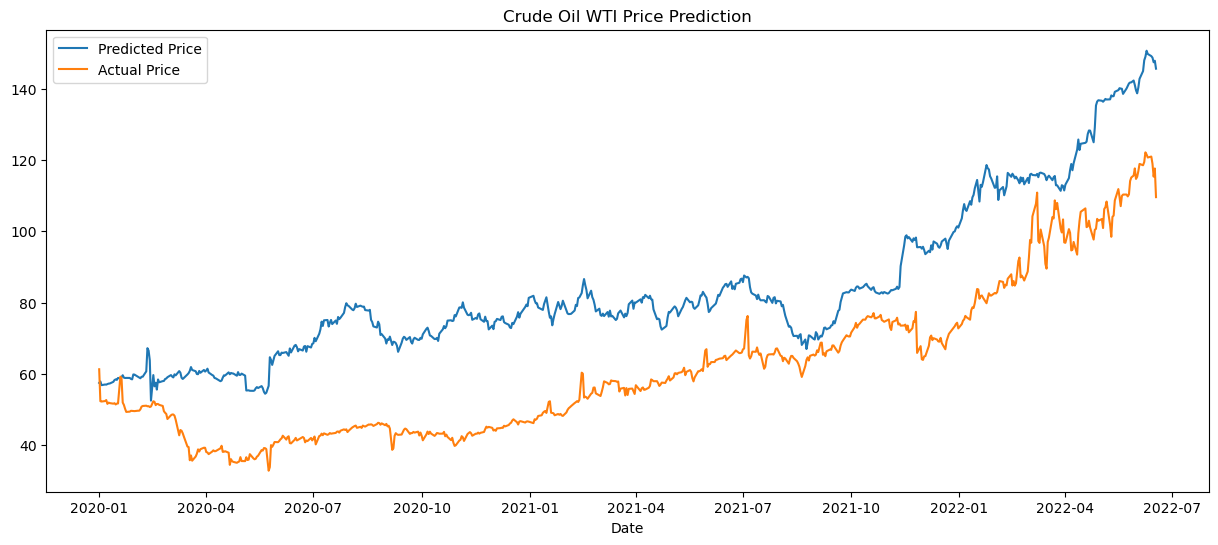

In [19]:
test_prices.plot(figsize = (15, 6), title = "Crude Oil WTI Price Prediction")
plt.show()

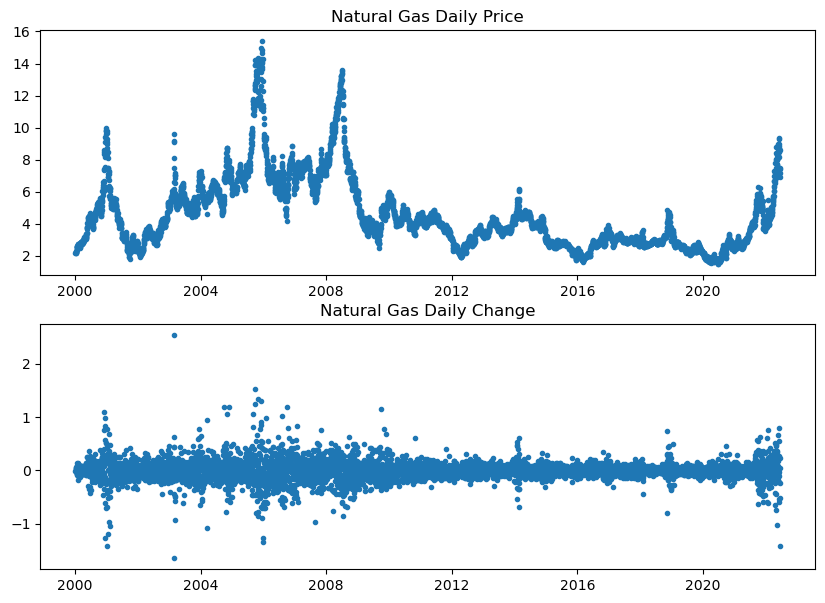

In [20]:
natural_price = natural['Close']
natural_diff = natural_price.diff().dropna()
natural_price = natural_price.iloc[1:]

plt.figure(figsize = (10, 7))
plt.subplot(2, 1, 1)
plt.plot(natural_price, '.')
plt.title('Natural Gas Daily Price')

plt.subplot(2, 1, 2)
plt.plot(natural_diff, '.')
plt.title('Natural Gas Daily Change')
plt.show()

In [21]:
X_train = natural_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()].values.reshape(-1, 1)
natural_price_train = natural_price[:dt.datetime(year = 2020, month = 1, day = 1).date()]
natural_diff_train = natural_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()]
natural_price_test = natural_price[dt.datetime(year = 2020, month = 1, day = 1).date():]

model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 1000, random_state = 36)
model.fit(X_train)

GaussianHMM(n_components=2, n_iter=1000, random_state=36)

In [22]:
print(f"Start probabilities:\n{model.startprob_}\n") # Most likely to start in state 0
print(f"Transition matrix:\n{model.transmat_}\n") # Most likely to stay in same state
print(f"Gaussian Distribution Means:\n{model.means_}\n") # State 0 is slight increase, 1 is slight decrease
print(f"Gaussian Distribution Covariances:\n{model.covars_}") # Covariance of state 0 is larger than state 1

Start probabilities:
[6.48764657e-42 1.00000000e+00]

Transition matrix:
[[0.97114334 0.02885666]
 [0.01241305 0.98758695]]

Gaussian Distribution Means:
[[ 0.00526913]
 [-0.00226483]]

Gaussian Distribution Covariances:
[[[0.09534078]]

 [[0.00827416]]]


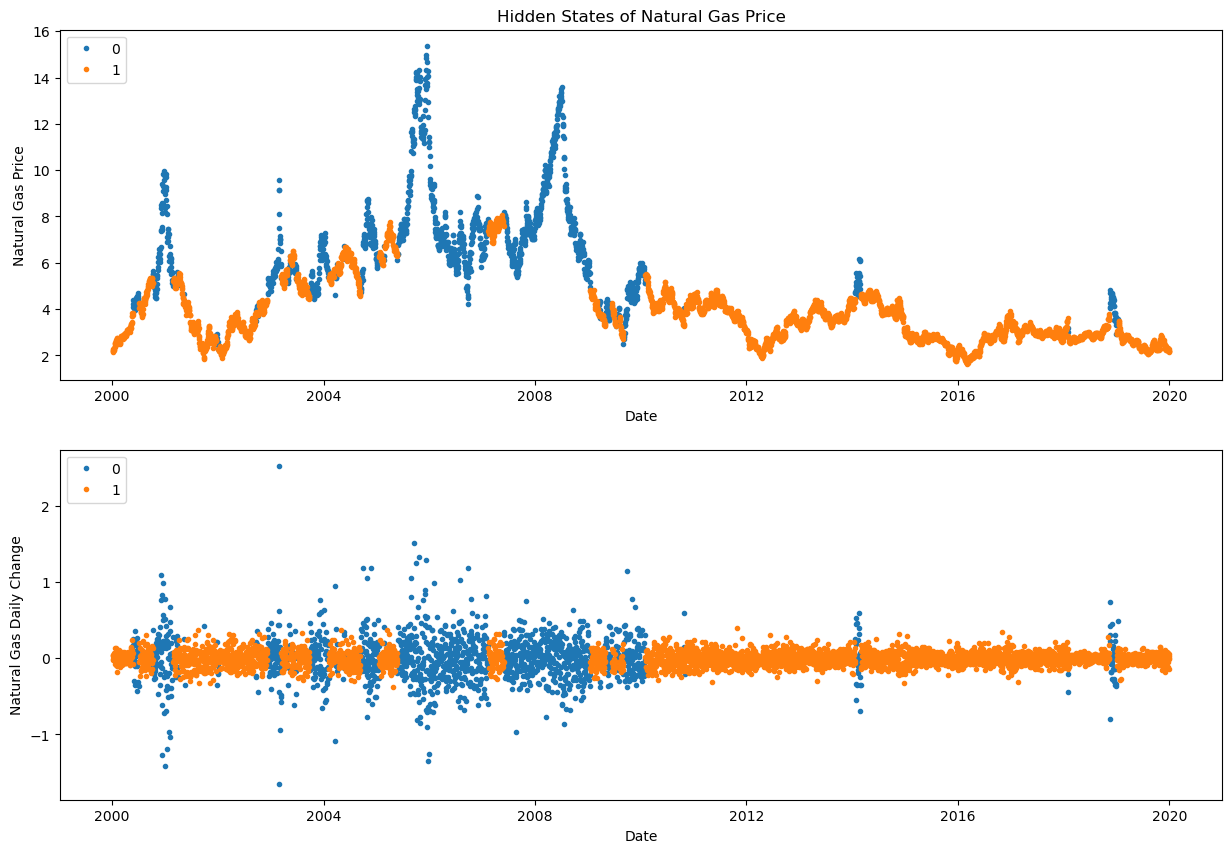

In [23]:
train_pred = model.predict(X_train)
model_states = np.sort(pd.unique(train_pred))


plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in model_states:
    state_idx = (train_pred == i)
    x = natural_price_train.index[state_idx]
    y = natural_price_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Natural Gas Price")
plt.title("Hidden States of Natural Gas Price")
plt.legend(model_states, loc = 'upper left')


plt.subplot(2,1,2)
for i in model_states:
    state_idx = (train_pred == i)
    x = natural_diff_train.index[state_idx]
    y = natural_diff_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Natural Gas Daily Change")
plt.legend(model_states, loc = 'upper left')

plt.show()

In [24]:
last_state = train_pred[-1]
future_states = [last_state]

num_days = natural_price_test.shape[0]
np.random.seed(475)

# Predict future states based on last known state
for _ in range(num_days - 1):
    future_states.append(np.random.choice(range(model.n_components), p = model.transmat_[future_states[-1]]))

# Predict changes in price based on predicted states
future_returns = []
for state in future_states:
    future_returns.append(np.random.normal(model.means_[state][0], np.sqrt(model.covars_[state][0]))[0])

predicted_prices = [natural_price_train[-1]]
for ret in future_returns:
    predicted_prices.append(predicted_prices[-1] + ret)
    

predicted_prices = pd.Series(predicted_prices[1:], index = natural_price_test.index[0:(len(predicted_prices) - 1)])
test_prices = pd.concat([predicted_prices, natural_price_test[0:len(predicted_prices)]], axis = 1)
test_prices.columns = ['Predicted Price', 'Actual Price']

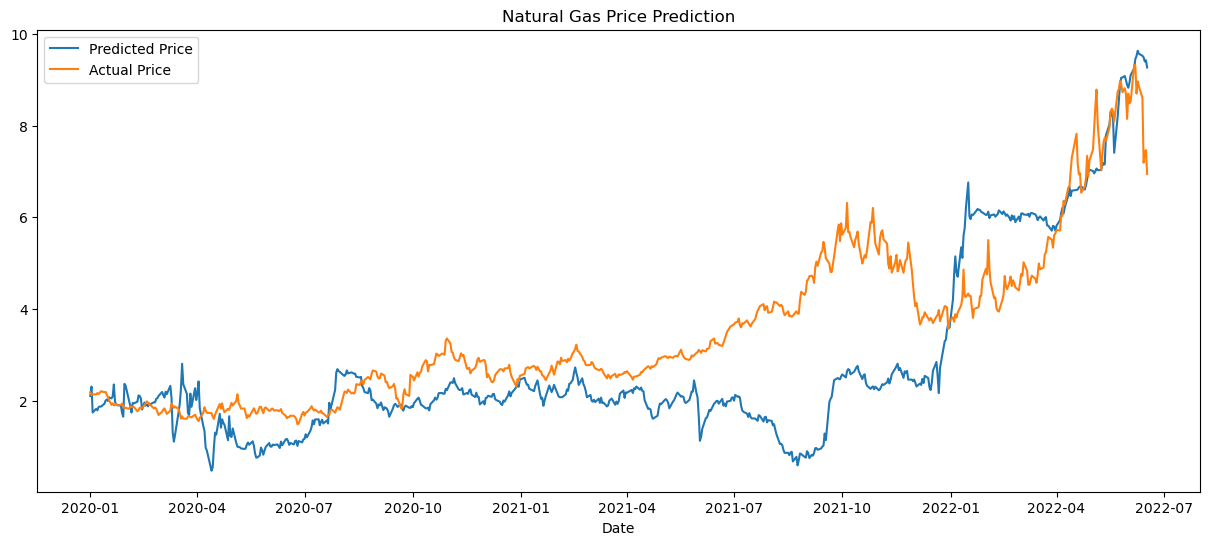

In [25]:
test_prices.plot(figsize = (15, 6), title = "Natural Gas Price Prediction")
plt.show()

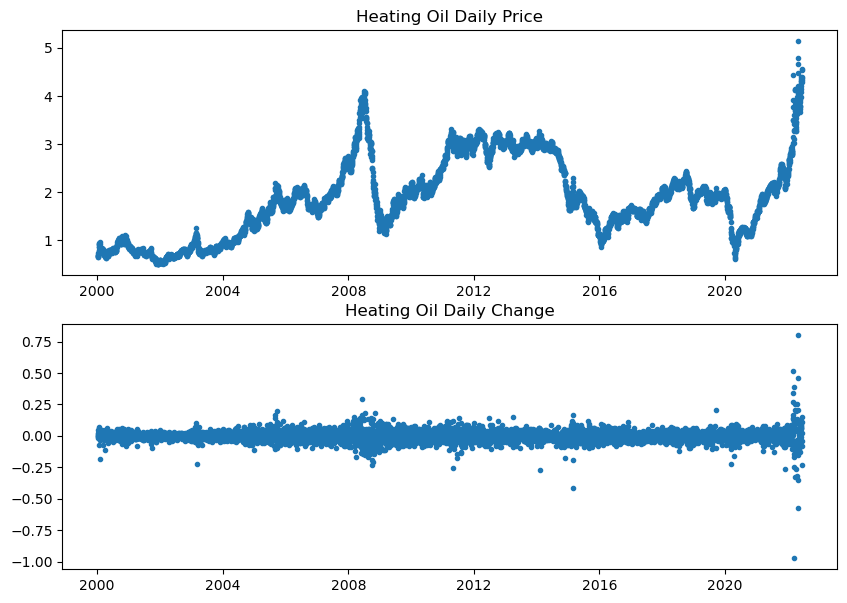

In [26]:
heating_price = heating['Close']
heating_diff = heating_price.diff().dropna()
heating_price = heating_price.iloc[1:]

plt.figure(figsize = (10, 7))
plt.subplot(2, 1, 1)
plt.plot(heating_price, '.')
plt.title('Heating Oil Daily Price')

plt.subplot(2, 1, 2)
plt.plot(heating_diff, '.')
plt.title('Heating Oil Daily Change')
plt.show()

In [27]:
X_train = heating_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()].values.reshape(-1, 1)
heating_price_train = heating_price[:dt.datetime(year = 2020, month = 1, day = 1).date()]
heating_diff_train = heating_diff[:dt.datetime(year = 2020, month = 1, day = 1).date()]
heating_price_test = heating_price[dt.datetime(year = 2020, month = 1, day = 1).date():]

model = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 1000, random_state = 36)
model.fit(X_train)

GaussianHMM(n_components=3, n_iter=1000, random_state=36)

In [28]:
print(f"Start probabilities:\n{model.startprob_}\n") # Most likely to start in state 0
print(f"Transition matrix:\n{model.transmat_}\n") # Most likely to stay in same state
print(f"Gaussian Distribution Means:\n{model.means_}\n") # State 0 is increase, 1 is small increase, and 2 is large decrease
print(f"Gaussian Distribution Covariances:\n{model.covars_}") # Covariance of state 0 is smallest, then state 1, and state 2 has largest covariance

Start probabilities:
[1.00000000e+000 1.90949696e-122 2.82547392e-068]

Transition matrix:
[[9.78097304e-01 5.89832039e-09 2.19026900e-02]
 [6.30537250e-03 9.39250039e-01 5.44445888e-02]
 [1.11355309e-02 6.74191720e-03 9.82122552e-01]]

Gaussian Distribution Means:
[[ 0.00135154]
 [-0.00455181]
 [ 0.00020973]]

Gaussian Distribution Covariances:
[[[0.0003724 ]]

 [[0.00742291]]

 [[0.00131993]]]


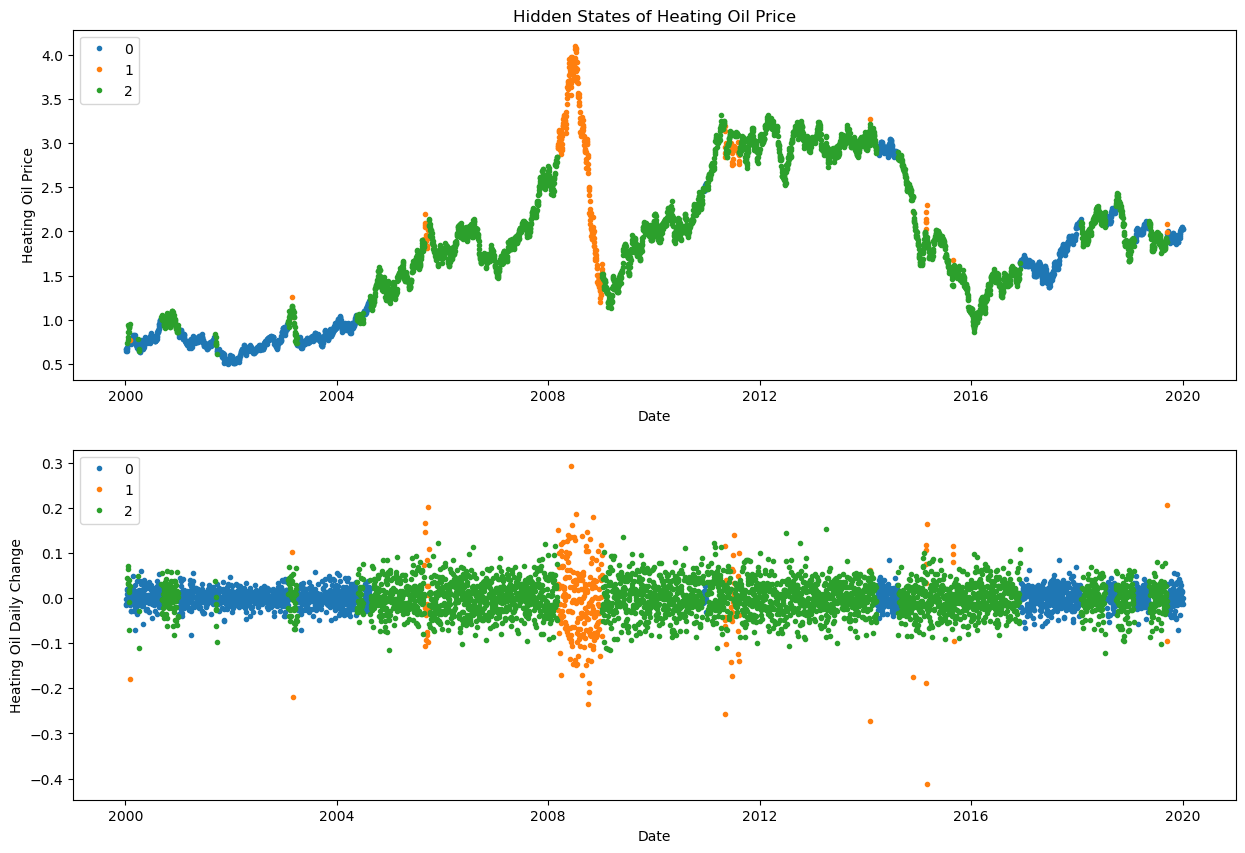

In [29]:
train_pred = model.predict(X_train)
model_states = np.sort(pd.unique(train_pred))


plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in model_states:
    state_idx = (train_pred == i)
    x = heating_price_train.index[state_idx]
    y = heating_price_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Heating Oil Price")
plt.title("Hidden States of Heating Oil Price")
plt.legend(model_states, loc = 'upper left')


plt.subplot(2,1,2)
for i in model_states:
    state_idx = (train_pred == i)
    x = heating_diff_train.index[state_idx]
    y = heating_diff_train.iloc[state_idx]
    plt.plot(x, y, '.')
    
plt.xlabel("Date")
plt.ylabel("Heating Oil Daily Change")
plt.legend(model_states, loc = 'upper left')

plt.show()

In [30]:
last_state = train_pred[-1]
future_states = [last_state]

num_days = heating_price_test.shape[0]
np.random.seed(475)

# Predict future states based on last known state
for _ in range(num_days - 1):
    future_states.append(np.random.choice(range(model.n_components), p = model.transmat_[future_states[-1]]))

# Predict changes in price based on predicted states
future_returns = []
for state in future_states:
    future_returns.append(np.random.normal(model.means_[state][0], np.sqrt(model.covars_[state][0]))[0])

predicted_prices = [heating_price_train[-1]]
for ret in future_returns:
    predicted_prices.append(predicted_prices[-1] + ret)
    

predicted_prices = pd.Series(predicted_prices[1:], index = heating_price_test.index[0:(len(predicted_prices) - 1)])
test_prices = pd.concat([predicted_prices, heating_price_test[0:len(predicted_prices)]], axis = 1)
test_prices.columns = ['Predicted Price', 'Actual Price']

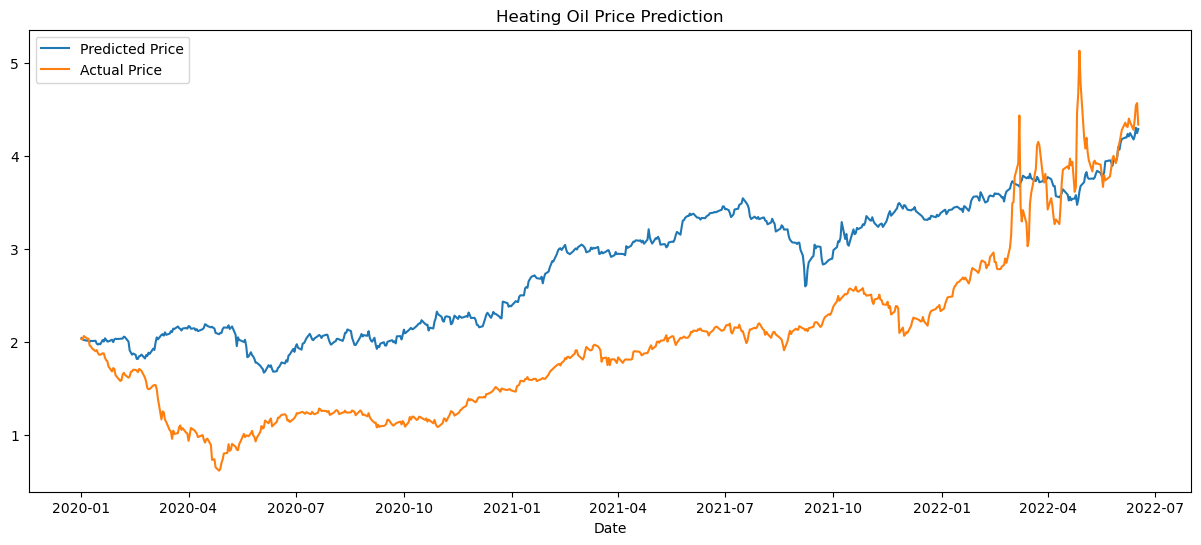

In [31]:
test_prices.plot(figsize = (15, 6), title = "Heating Oil Price Prediction")
plt.show()

Takeaways: This model performed very well for projecting long-term results. This is what we would expect from a simple model (we don't think that we can predict every individual day extremely well because this just isn't practical for the stock market but we are able to project long-term results). 